In [18]:
import sys
import os
sys.path.append('../')

In [19]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from optimizers import IPS, AdaIPS_S
from utils.getData import getData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.t_losses = []
        self.v_losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [21]:
epochs = 10
batch_size = 64


In [22]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainloader, trainset, testloader, testset, validationloader, valset = getData('MNIST', transform=transform, batch_size=batch_size)

In [23]:
def train(model, optimizer, epochs=2):
    model.train()
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            running_loss += loss
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
        
        # model.t_losses.append(running_loss / len(trainloader.dataset))
            

    print("Training complete.")
    return model

In [ ]:
def test(model, per_class=False):
    model.eval()
    for i, (inputs, labels) in enumerate(testloader):
        with torch.no_grad():
            output = model(inputs)
            output = output.argmax(axis=1)
        
        print("predicted classes:", np.unique(output.detach().numpy()))
        precision, recall, fscore, _ = precision_recall_fscore_support(labels, output.detach().numpy(), average='weighted')
        print(f"accuracy: {accuracy_score(labels, output.detach().numpy())}")
        

        print(f"precision: {precision}\nrecall: {recall}\nfscore: {fscore}")
        if not per_class: 
            return
        
        for i in range(10):
            print(f"Class {i} -> Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {fscore[i]:.4f}")


In [25]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

initialized optimizer with per layer learning rate: False
AdaIPS_S (
Parameter Group 0
    T0: 7500.0
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.3225090503692627
Epoch 1, Step 100, Loss: 0.46121376752853394
Epoch 1, Step 200, Loss: 0.8057931065559387
Epoch 1, Step 300, Loss: 0.4485025703907013
Epoch 1, Step 400, Loss: 0.27749019861221313
Epoch 1, Step 500, Loss: 0.15759186446666718
Epoch 1, Step 600, Loss: 0.3035668432712555
Epoch 1, Step 700, Loss: 0.35069963335990906
Epoch 2, Step 0, Loss: 0.09292113780975342
Epoch 2, Step 100, Loss: 0.04951771721243858
Epoch 2, Step 200, Loss: 0.04536622017621994
Epoch 2, Step 300, Loss: 0.052445344626903534
Epoch 2, Step 400, Loss: 0.11837028712034225
Epoch 2, Step 500, Loss: 0.11033431440591812
Epoch 2, Step 600, Loss: 0.30814045667648315
Epoch 2, Step 700, Loss: 0.18340158462524414
Epoch 3, Step 0, Loss: 0.04735815152525902
Epoch 3, Step 100, Loss: 0.036425866186618805
Epoch 3, Step 200, Loss: 0.

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [26]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=epochs)

IPS (
Parameter Group 0
    T: 7500.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.3144350051879883
Epoch 1, Step 100, Loss: 1.0275993347167969
Epoch 1, Step 200, Loss: 0.7461443543434143
Epoch 1, Step 300, Loss: 0.5553188323974609
Epoch 1, Step 400, Loss: 0.5786617398262024
Epoch 1, Step 500, Loss: 0.5820832252502441
Epoch 1, Step 600, Loss: 0.4853198826313019
Epoch 1, Step 700, Loss: 0.32570040225982666
Epoch 2, Step 0, Loss: 0.4223187267780304
Epoch 2, Step 100, Loss: 0.5175292491912842
Epoch 2, Step 200, Loss: 0.4653073251247406
Epoch 2, Step 300, Loss: 0.3136746883392334
Epoch 2, Step 400, Loss: 0.4668533504009247
Epoch 2, Step 500, Loss: 0.3868192732334137
Epoch 2, Step 600, Loss: 0.5192584991455078
Epoch 2, Step 700, Loss: 0.38858267664909363
Epoch 3, Step 0, Loss: 0.5024661421775818
Epoch 3, Step 100, Loss: 0.3537561893463135
Epoch 3, Step 200, Loss: 0.5135165452957153
Epoch 3, Step 300, Loss: 0.24086540937423706
Epoch 3, Step 400, Loss: 0.2982247471809387
Epoch 3, Step 500, L

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [27]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=epochs)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.298304557800293
Epoch 1, Step 100, Loss: 0.2846851646900177
Epoch 1, Step 200, Loss: 0.4020357131958008
Epoch 1, Step 300, Loss: 0.19208677113056183
Epoch 1, Step 400, Loss: 0.3450469970703125
Epoch 1, Step 500, Loss: 0.1235453188419342
Epoch 1, Step 600, Loss: 0.10652683675289154
Epoch 1, Step 700, Loss: 0.1786148101091385
Epoch 2, Step 0, Loss: 0.3439258635044098
Epoch 2, Step 100, Loss: 0.07897020131349564
Epoch 2, Step 200, Loss: 0.06540384888648987
Epoch 2, Step 300, Loss: 0.14599214494228363
Epoch 2, Step 400, Loss: 0.18619662523269653
Epoch 2, Step 500, Loss: 0.06661009788513184
Epoch 2, Step 600, Loss: 0.158522367477417
Epoch 2, Step 700, Loss: 0.2888357937335968
Epoch 3, Step 0, Loss: 0.16063013672828674
Epoch 3, Step 100, Loss: 0.0901

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [28]:
rmsModel = SimpleNN().to(device)
rmsOptimizer = torch.optim.RMSprop(rmsModel.parameters(), lr=1e-3)
train(rmsModel, rmsOptimizer, epochs=epochs)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3190157413482666
Epoch 1, Step 100, Loss: 0.37738004326820374
Epoch 1, Step 200, Loss: 0.18401861190795898
Epoch 1, Step 300, Loss: 0.2946602702140808
Epoch 1, Step 400, Loss: 0.391198992729187
Epoch 1, Step 500, Loss: 0.2529309391975403
Epoch 1, Step 600, Loss: 0.12049658596515656
Epoch 1, Step 700, Loss: 0.06212514266371727
Epoch 2, Step 0, Loss: 0.1706441193819046
Epoch 2, Step 100, Loss: 0.2723291218280792
Epoch 2, Step 200, Loss: 0.08746262639760971
Epoch 2, Step 300, Loss: 0.17768830060958862
Epoch 2, Step 400, Loss: 0.14815102517604828
Epoch 2, Step 500, Loss: 0.03913579136133194
Epoch 2, Step 600, Loss: 0.10737212002277374
Epoch 2, Step 700, Loss: 0.06874727457761765
Epoch 3, Step 0, Loss: 0.053228579461574554
Epoch 3, Step 100, Loss: 0.110

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [29]:
test(adaIpsModel)
# test(ipsModel)
# test(adamModel
# test(rmsModel)

[0 1 2 3 4 5 6 7 8 9]
0.9747
0.9747871119803309 0.9747 0.9747067272136409
Class 0 -> Precision: 0.9798, Recall: 0.9898, F1-score: 0.9848
Class 1 -> Precision: 0.9921, Recall: 0.9912, F1-score: 0.9916
Class 2 -> Precision: 0.9814, Recall: 0.9709, F1-score: 0.9761
Class 3 -> Precision: 0.9685, Recall: 0.9743, F1-score: 0.9714
Class 4 -> Precision: 0.9695, Recall: 0.9715, F1-score: 0.9705
Class 5 -> Precision: 0.9751, Recall: 0.9641, F1-score: 0.9696
Class 6 -> Precision: 0.9791, Recall: 0.9760, F1-score: 0.9775
Class 7 -> Precision: 0.9840, Recall: 0.9601, F1-score: 0.9719
Class 8 -> Precision: 0.9606, Recall: 0.9774, F1-score: 0.9690
Class 9 -> Precision: 0.9551, Recall: 0.9693, F1-score: 0.9621


[2.3225090503692627, 0.46121376752853394, 0.8057931065559387, 0.4485025703907013, 0.27749019861221313, 0.15759186446666718, 0.3035668432712555, 0.35069963335990906, 0.09292113780975342, 0.04951771721243858, 0.04536622017621994, 0.052445344626903534, 0.11837028712034225, 0.11033431440591812, 0.30814045667648315, 0.18340158462524414, 0.04735815152525902, 0.036425866186618805, 0.24384592473506927, 0.1582624316215515, 0.04738030582666397, 0.033084332942962646, 0.07283098995685577, 0.06583545356988907, 0.09724922478199005, 0.045217033475637436, 0.05287584662437439, 0.10711046308279037, 0.07191545516252518, 0.00996348261833191, 0.04434088617563248, 0.07106732577085495, 0.1266160011291504, 0.1358669549226761, 0.09693408757448196, 0.05509379506111145, 0.005468357354402542, 0.1278427541255951, 0.00873294286429882, 0.028517208993434906, 0.032618653029203415, 0.06711433827877045, 0.046798381954431534, 0.006850857753306627, 0.09532789885997772, 0.012449397705495358, 0.12796686589717865, 0.02651460

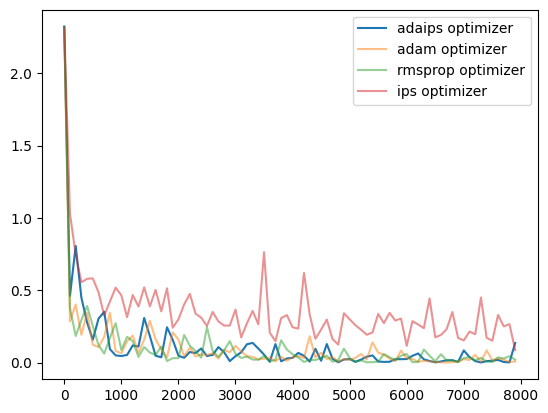

In [30]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    (rmsModel, 'rmsprop optimizer'),
    (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    print(model.t_losses)
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )

plt.legend()
plt.show()

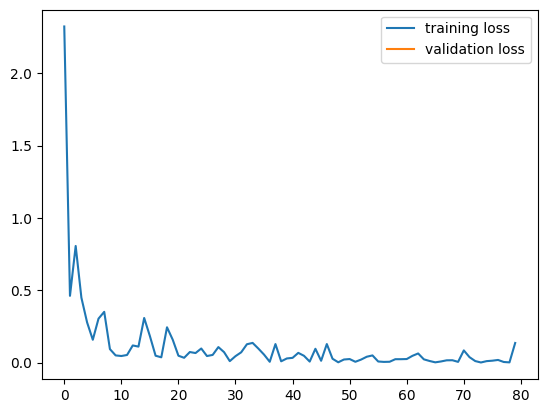

In [31]:

plt.plot([t for t in adaIpsModel.t_losses], label='training loss')
plt.plot([v for v in adaIpsModel.v_losses], label='validation loss')
plt.legend()
plt.show()
